# Prepare Training Data

In [8]:
import pywt
import pandas as pd
import numpy as np


def generate_windows(df, window_size, shift):
    N = len(data)
    
    df = df.reset_index()
    
    windows = []

    k = 0
    window_id = 1
    while (N-k-window_size) >= 0:
        window = df[['ena_data','ena_bruta_bacia_mwmed']].iloc[(N-k-window_size):(N-k)].reset_index()
        window['window_id'] = window_id
        window['window_index'] = range(0,window_size)
        window.set_index('ena_data',inplace=True)
        
        piv = window.pivot(index='window_id', columns='window_index', values="ena_bruta_bacia_mwmed")
        piv['from_date'] = min(window.index.date)
        piv['to_date'] = max(window.index.date)
        
        windows.append(piv)
        
        k = k + shift
        window_id += 1
        
    return pd.concat(windows)


def split_data(data, split = [.7,.1,.2]):

    N = len(data)

    n_valid = int(split[1]*N) 
    n_test  = int(split[2]*N)
    n_train = N - n_valid - n_test

    train = data[:n_train]
    valid = data[n_train:n_train+n_valid]
    test = data[n_train+n_valid:n_train+n_valid+n_test]
    
    return train, valid, test


def split_xy(data, input_width):
    ts_values = data.drop(['from_date','to_date'], axis=1)
    
    x_col = ts_values.columns[:input_width]
    y_col = ts_values.columns[input_width:]
    
    return ts_values[x_col], ts_values[y_col]


def zscore(data, avg, std):
    
    scaled = data.sub(avg)
    scaled = scaled.divide(std)
    
    return scaled

def extract_features(ts, wavelet, include_ts = True):
    
    level = int(np.log(len(ts)))
    if include_ts is True:
        features = ts
    else:
        features = np.array([])
        
    cA = ts
    for l in range(1,level+1):
        cA, cD = pywt.dwt(cA, wavelet)
        
        features = np.concatenate([features,cD])
        
    features = np.concatenate([features,cA])
    
    return features

In [53]:
def generate_training_data(data, input_width, target_width, wavelet, include_ts, shift, split):
    
    # Generate Windows
    print("Generating windows...")
    window_size = input_width + target_width
    windows = generate_windows(data, window_size, shift)
    
    # Split training data
    print("Spliting data into training, validation and testing datasets...")
    train, valid, test = split_data(windows, split)
    
    # Split X and Y
    print("Spliting model inputs and outputs (X and Y)")
    train_x, train_y = split_xy(train, input_width)
    valid_x, valid_y = split_xy(valid, input_width)
    test_x, test_y = split_xy(test, input_width)
    
    # Scale Data with Training Dataset
    print("Calculate average and standard deviation for training dataset...")
    ts_data = train.values[:,:-2] # Remove last columns with datetime

    train_avg = ts_data.reshape(1,ts_data.shape[0]*ts_data.shape[1]).mean()
    train_std = ts_data.reshape(1,ts_data.shape[0]*ts_data.shape[1]).std()
    print("Training dataset average: {}".format(round(train_avg,2)))
    print("Training dataset standard deviation: {}".format(round(train_std,2)))

    print("Scaling training, validation and testing datasets using z-score...")
    scaled_train_x = zscore(train_x, train_avg, train_std)
    scaled_train_y = zscore(train_y, train_avg, train_std)
    scaled_valid_x = zscore(valid_x, train_avg, train_std)
    scaled_valid_y = zscore(valid_y, train_avg, train_std)
    scaled_test_x  = zscore(test_x, train_avg, train_std)
    scaled_test_y  = zscore(test_y, train_avg, train_std)
    
    
    # Extract Features
    def get_dwt(x):    
        return extract_features(x, wavelet, include_ts)
    
    if wavelet == None:
        print("Returning values without DWT transformation.")
        return (scaled_train_x, scaled_valid_x, scaled_test_x,
                scaled_train_y, scaled_valid_y, scaled_test_y, train_avg, train_std)
    else:
        print("Returning values with DWT transformation with {} wavelet.".format(wavelet))
        dwt_scaled_train_x = scaled_train_x.apply(lambda x: get_dwt(x), axis=1, result_type='expand')
        dwt_scaled_valid_x = scaled_valid_x.apply(lambda x: get_dwt(x), axis=1, result_type='expand')
        dwt_scaled_test_x  = scaled_test_x.apply(lambda x: get_dwt(x), axis=1, result_type='expand')
    
        return (dwt_scaled_train_x, dwt_scaled_valid_x, dwt_scaled_test_x,
                scaled_train_y, scaled_valid_y, scaled_test_y, train_avg, train_std)

# 1. MLP only

In [54]:
# Training data generation parameters

data         = catalog.load("ena-diario-parana")
input_width  = 128
target_width = 15 
wavelet      = None
include_ts   = True
shift        = 1
split        = [.8, .1, .1]

2021-12-14 12:19:52,580 - kedro.io.data_catalog - INFO - Loading data from `ena-diario-parana` (CSVDataSet)...


In [55]:
%%time

X_train, X_valid, X_test, Y_train, Y_valid, Y_test, train_avg, train_std = generate_training_data(
    data, input_width, target_width, wavelet, include_ts, shift, split
)

Generating windows...
Spliting data into training, validation and testing datasets...
Spliting model inputs and outputs (X and Y)
Calculate average and standard deviation for training dataset...
Training dataset average: 16144.77
Training dataset standard deviation: 7689.77
Scaling training, validation and testing datasets using z-score...
Returning values without DWT transformation.
CPU times: user 1min 2s, sys: 208 ms, total: 1min 2s
Wall time: 1min 3s


## 1.1. Compile MLP Model

In [56]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (RootMeanSquaredError,
                                      MeanAbsoluteError,
                                      MeanSquaredError,
                                      MeanAbsolutePercentageError)

In [61]:
input_dim = len(X_train.columns) # Number of points in X samples
output_dim = 15 # Number of points in Y samples
layer_1 = 800 # Number of neurons on first layer
layer_2 = 600 # Number of neurons on second layer
lr = 0.0000001 # MLP learning rate
metrics = ['rmse','mae','mse','mape']

In [62]:
def create_model(input_dim, output_dim, layer_1, layer_2, lr, metrics):
    
    def parse_metrics(metrics):
        metric_objs = []
        if 'rmse' in metrics:
            metric_objs.append(RootMeanSquaredError())
        if 'mae' in metrics:
            metric_objs.append(MeanAbsoluteError())
        if 'mse' in metrics:
            metric_objs.append(MeanSquaredError())
        if 'mape' in metrics:
            metric_objs.append(MeanAbsolutePercentageError())
        return metric_objs
    
    metric_objs = parse_metrics(metrics)

    model = keras.Sequential([
        layers.Dense(
            layer_1,
            input_dim=input_dim,
            activation='relu',
        ),
        layers.Dense(
            layer_2,
            activation='relu',
        ),
        layers.Dense(output_dim),
    ])

    model.compile(
        optimizer=Adam(lr),
        loss='mse',
        metrics=metric_objs,
    )
    
    return model


In [63]:
model = create_model(input_dim, output_dim, layer_1, layer_2, lr, metrics)

## 1.2. Training the model

In [64]:
import os
from tensorflow.keras.callbacks import TensorBoard

def train_model(model,
        X_train, Y_train,
        X_valid, Y_valid,
        epochs,
        tensorboard_log_dir,
        train_index,
        tensorboard_hist_freq=1):
    
    # Callback
    
    folder_name = 'MLP_train_index_{}'.format(str(train_index))
    log_dir = os.path.join(tensorboard_log_dir, folder_name)

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    tensorboard_cbk = TensorBoard(log_dir=log_dir,
        histogram_freq=tensorboard_hist_freq
    )

    history = model.fit(
        x=X_train,
        y=Y_train,
        validation_data=(X_valid, Y_valid),
        epochs=epochs,
        verbose=1,
        callbacks=tensorboard_cbk,
    )
    
    return model, history

    

In [66]:
epochs = 20
tensorboard_log_dir = '/usr/src/code/data/tensorboard'
train_index = 'final_only_mlp_20_epochs'

In [67]:
%%time

trained_model, history = train_model(model,
    X_train, Y_train,
    X_valid, Y_valid,
    epochs,
    tensorboard_log_dir,
    train_index
)

Epoch 1/20
194/197 [============================>.] - ETA: 0s - loss: 1.1366 - root_mean_squared_error: 1.0661 - mean_absolute_error: 0.8258 - mean_squared_error: 1.1366 - mean_absolute_percentage_error: 343.0264

2021-12-14 12:25:58.230792: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24576000 exceeds 10% of free system memory.
2021-12-14 12:25:58.483847: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 115200000 exceeds 10% of free system memory.


197/197 [==============================] - 5s 16ms/step - loss: 1.1346 - root_mean_squared_error: 1.0652 - mean_absolute_error: 0.8249 - mean_squared_error: 1.1346 - mean_absolute_percentage_error: 341.2604 - val_loss: 1.1103 - val_root_mean_squared_error: 1.0537 - val_mean_absolute_error: 0.8258 - val_mean_squared_error: 1.1103 - val_mean_absolute_percentage_error: 236.1627
Epoch 2/20
197/197 [==============================] - 2s 10ms/step - loss: 1.1172 - root_mean_squared_error: 1.0570 - mean_absolute_error: 0.8182 - mean_squared_error: 1.1172 - mean_absolute_percentage_error: 334.4645 - val_loss: 1.0968 - val_root_mean_squared_error: 1.0473 - val_mean_absolute_error: 0.8202 - val_mean_squared_error: 1.0968 - val_mean_absolute_percentage_error: 232.8645


2021-12-14 12:26:00.590181: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24576000 exceeds 10% of free system memory.
2021-12-14 12:26:00.626769: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 115200000 exceeds 10% of free system memory.


Epoch 3/20
193/197 [============================>.] - ETA: 0s - loss: 1.1038 - root_mean_squared_error: 1.0506 - mean_absolute_error: 0.8124 - mean_squared_error: 1.1038 - mean_absolute_percentage_error: 328.0553

2021-12-14 12:26:03.205847: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24576000 exceeds 10% of free system memory.


197/197 [==============================] - 3s 14ms/step - loss: 1.1003 - root_mean_squared_error: 1.0489 - mean_absolute_error: 0.8116 - mean_squared_error: 1.1003 - mean_absolute_percentage_error: 327.8383 - val_loss: 1.0836 - val_root_mean_squared_error: 1.0410 - val_mean_absolute_error: 0.8147 - val_mean_squared_error: 1.0836 - val_mean_absolute_percentage_error: 229.6405
Epoch 4/20
197/197 [==============================] - 3s 15ms/step - loss: 1.0838 - root_mean_squared_error: 1.0410 - mean_absolute_error: 0.8051 - mean_squared_error: 1.0838 - mean_absolute_percentage_error: 322.1277 - val_loss: 1.0709 - val_root_mean_squared_error: 1.0349 - val_mean_absolute_error: 0.8093 - val_mean_squared_error: 1.0709 - val_mean_absolute_percentage_error: 226.5801
Epoch 5/20
197/197 [==============================] - 2s 11ms/step - loss: 1.0677 - root_mean_squared_error: 1.0333 - mean_absolute_error: 0.7988 - mean_squared_error: 1.0677 - mean_absolute_percentage_error: 315.6465 - val_loss: 1.0

## 1.3. Evaluate Model

In [68]:
def evaluate(model, X_test, Y_test):
    evaluation_results = model.evaluate(X_test, Y_test)
    
    return evaluation_results

In [82]:
results_1 = evaluate(trained_model, X_test, Y_test)

25/25 [==============================] - 0s 4ms/step - loss: 0.7382 - root_mean_squared_error: 0.8592 - mean_absolute_error: 0.6757 - mean_squared_error: 0.7382 - mean_absolute_percentage_error: 524.6260


In [83]:
results_1

[0.7382197380065918,
 0.8591971397399902,
 0.67566978931427,
 0.7382197380065918,
 524.6260375976562]

## 1.4. Plot Predictions

In [84]:
def get_predictions(m, X):
    pred = m.predict(X)
    return pred

In [85]:
Y_pred = get_predictions(trained_model, X_test)

In [86]:
def plot_predictions(X, Y, Y_pred):
    
    
    df1 = pd.DataFrame({
    't': range(1,len(X)+1),
    'X': X,
    })
    
    df1['Y'] = np.nan
    df1['Y_pred'] = np.nan
    df1.set_index('t', inplace=True)
    
    df2 = pd.DataFrame({
        't': range(len(X),len(X)+len(Y)),
        'Y': Y,
        'Y_pred': Y_pred
    })
    df2['X'] = np.nan
    df2.set_index('t', inplace=True)
    
    pred_df = pd.concat([df1,df2])
    
    pred_df.plot()
    
    return pred_df

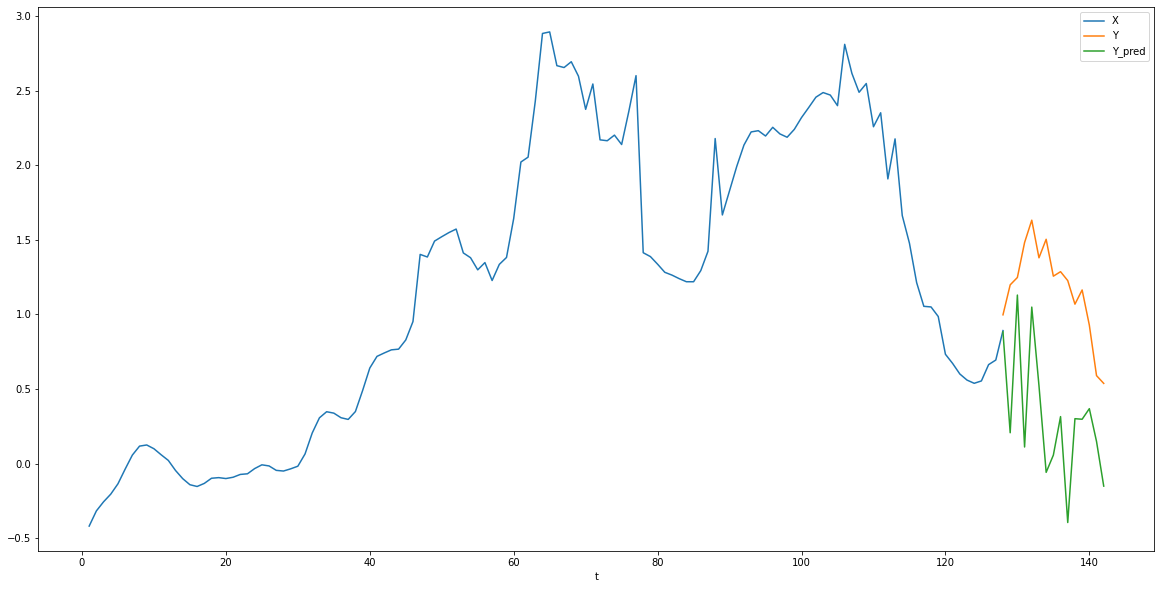

In [87]:
import matplotlib.pyplot as plt

idx = 100
plt.rcParams["figure.figsize"] = (20, 10)

df = plot_predictions(X_test.iloc[idx].values[:128], Y_test.iloc[idx].values, Y_pred[idx])

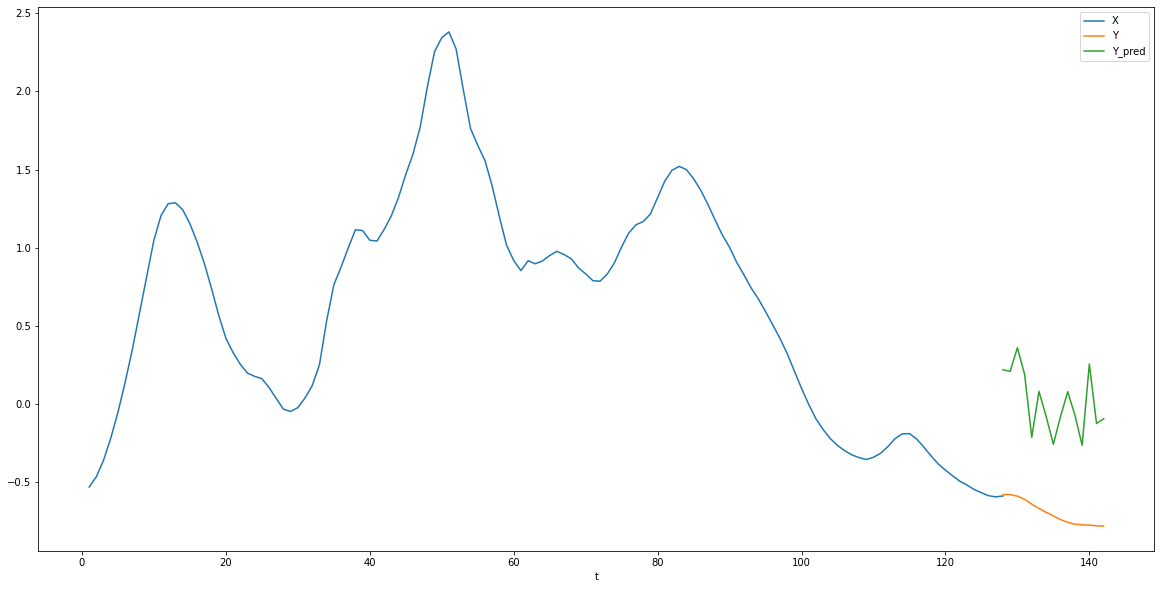

In [91]:
import matplotlib.pyplot as plt

idx = 785
plt.rcParams["figure.figsize"] = (20, 10)

df = plot_predictions(X_test.iloc[idx].values[:128], Y_test.iloc[idx].values, Y_pred[idx])

# 2. MLP with DWT and times series

## 2.1. Generate training data

In [92]:
# Training data generation parameters

data         = catalog.load("ena-diario-parana")
input_width  = 128
target_width = 15 
wavelet      = 'db8'
include_ts   = True
shift        = 1
split        = [.8, .1, .1]

2021-12-14 12:35:31,809 - kedro.io.data_catalog - INFO - Loading data from `ena-diario-parana` (CSVDataSet)...


In [93]:
%%time

X_train, X_valid, X_test, Y_train, Y_valid, Y_test, train_avg, train_std = generate_training_data(
    data, input_width, target_width, wavelet, include_ts, shift, split
)

Generating windows...
Spliting data into training, validation and testing datasets...
Spliting model inputs and outputs (X and Y)
Calculate average and standard deviation for training dataset...
Training dataset average: 16144.77
Training dataset standard deviation: 7689.77
Scaling training, validation and testing datasets using z-score...
Returning values with DWT transformation with db8 wavelet.
CPU times: user 1min 8s, sys: 470 ms, total: 1min 8s
Wall time: 1min 9s


## 2.2. Compile model

In [102]:
input_dim = len(X_train.columns) # Number of points in X samples
output_dim = 15 # Number of points in Y samples
layer_1 = 800 # Number of neurons on first layer
layer_2 = 600 # Number of neurons on second layer
lr = 0.0000001 # MLP learning rate
metrics = ['rmse','mae','mse','mape']

In [103]:
model = create_model(input_dim, output_dim, layer_1, layer_2, lr, metrics)

# 2.3. Training the model

In [105]:
epochs = 60
tensorboard_log_dir = '/usr/src/code/data/tensorboard'
train_index = 'final_mlp_dwt_and_ts_60_epochs'

In [106]:
%%time

trained_model, history = train_model(model,
    X_train, Y_train,
    X_valid, Y_valid,
    epochs,
    tensorboard_log_dir,
    train_index
)

Epoch 1/60
197/197 [==============================] - 3s 13ms/step - loss: 1.6278 - root_mean_squared_error: 1.2758 - mean_absolute_error: 0.9474 - mean_squared_error: 1.6278 - mean_absolute_percentage_error: 656.4181 - val_loss: 1.6836 - val_root_mean_squared_error: 1.2975 - val_mean_absolute_error: 0.9912 - val_mean_squared_error: 1.6836 - val_mean_absolute_percentage_error: 423.4029
Epoch 2/60
197/197 [==============================] - 2s 12ms/step - loss: 1.5814 - root_mean_squared_error: 1.2575 - mean_absolute_error: 0.9341 - mean_squared_error: 1.5814 - mean_absolute_percentage_error: 640.8139 - val_loss: 1.6427 - val_root_mean_squared_error: 1.2817 - val_mean_absolute_error: 0.9792 - val_mean_squared_error: 1.6427 - val_mean_absolute_percentage_error: 415.0024
Epoch 3/60
197/197 [==============================] - 2s 12ms/step - loss: 1.5370 - root_mean_squared_error: 1.2398 - mean_absolute_error: 0.9211 - mean_squared_error: 1.5370 - mean_absolute_percentage_error: 626.8239 - va

197/197 [==============================] - 4s 19ms/step - loss: 0.9250 - root_mean_squared_error: 0.9618 - mean_absolute_error: 0.7155 - mean_squared_error: 0.9250 - mean_absolute_percentage_error: 409.2232 - val_loss: 1.0590 - val_root_mean_squared_error: 1.0291 - val_mean_absolute_error: 0.7833 - val_mean_squared_error: 1.0590 - val_mean_absolute_percentage_error: 286.3316
Epoch 23/60
197/197 [==============================] - 3s 13ms/step - loss: 0.9021 - root_mean_squared_error: 0.9498 - mean_absolute_error: 0.7065 - mean_squared_error: 0.9021 - mean_absolute_percentage_error: 401.7300 - val_loss: 1.0385 - val_root_mean_squared_error: 1.0191 - val_mean_absolute_error: 0.7752 - val_mean_squared_error: 1.0385 - val_mean_absolute_percentage_error: 281.6664
Epoch 24/60
197/197 [==============================] - 2s 11ms/step - loss: 0.8800 - root_mean_squared_error: 0.9381 - mean_absolute_error: 0.6976 - mean_squared_error: 0.8800 - mean_absolute_percentage_error: 393.0879 - val_loss: 1

197/197 [==============================] - 2s 12ms/step - loss: 0.5760 - root_mean_squared_error: 0.7589 - mean_absolute_error: 0.5591 - mean_squared_error: 0.5760 - mean_absolute_percentage_error: 300.7923 - val_loss: 0.7452 - val_root_mean_squared_error: 0.8633 - val_mean_absolute_error: 0.6448 - val_mean_squared_error: 0.7452 - val_mean_absolute_percentage_error: 224.3455
Epoch 44/60
197/197 [==============================] - 2s 11ms/step - loss: 0.5649 - root_mean_squared_error: 0.7516 - mean_absolute_error: 0.5535 - mean_squared_error: 0.5649 - mean_absolute_percentage_error: 299.2834 - val_loss: 0.7352 - val_root_mean_squared_error: 0.8574 - val_mean_absolute_error: 0.6398 - val_mean_squared_error: 0.7352 - val_mean_absolute_percentage_error: 223.4884
Epoch 45/60
197/197 [==============================] - 2s 10ms/step - loss: 0.5543 - root_mean_squared_error: 0.7445 - mean_absolute_error: 0.5481 - mean_squared_error: 0.5543 - mean_absolute_percentage_error: 298.0612 - val_loss: 0

# 2.4. Evaluate the model

In [ ]:
results_2 = evaluate(trained_model, X_test, Y_test)

## 2.5. Plot predicitions

In [ ]:
import matplotlib.pyplot as plt

idx = 100
plt.rcParams["figure.figsize"] = (20, 10)

df = plot_predictions(X_test.iloc[idx].values[:128], Y_test.iloc[idx].values, Y_pred[idx])